In [27]:
import math
import time
import os
import requests
from io import BytesIO
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.models as models
import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor


In [28]:
# Constants

ZOOM = 17
IMG_SIZE = (224, 224)
API_KEY = os.getenv("SATELLITE_API_KEY")

TRAIN_IMG_DIR = "train_images"
os.makedirs(TRAIN_IMG_DIR, exist_ok=True)
TEST_IMG_DIR = "test2_images"
os.makedirs(TEST_IMG_DIR, exist_ok=True)
CACHE_DIR = "artifacts"
os.makedirs(CACHE_DIR, exist_ok=True)

X_IMAGE_PATH = os.path.join(CACHE_DIR, "X_image.npy")
ROWS_PATH = os.path.join(CACHE_DIR, "kept_rows.npy")
DF_PATH = os.path.join(CACHE_DIR, "filtered_df.csv")

X_IMAGE_TEST2_PATH = os.path.join(CACHE_DIR, "X_image_test2.npy")
VALID_ROWS_TEST2_PATH = os.path.join(CACHE_DIR, "valid_rows_test2.npy")
FILTERED_TEST2_DF_PATH = os.path.join(CACHE_DIR, "filtered_test2_df.csv")



In [29]:
def latlon_to_tile(lat, lon, zoom):
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom
    x = int((lon + 180.0) / 360.0 * n)
    y = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return x, y


def download_images(df, img_dir, max_images=None):
    count = 0
    for _, row in df.iterrows():
        img_id, lat, lon = row["id"], row["lat"], row["long"]
        img_path = os.path.join(img_dir, f"{img_id}.png")

        if os.path.exists(img_path):
            continue

        x, y = latlon_to_tile(lat, lon, ZOOM)
        url = f"https://api.maptiler.com/tiles/satellite-v2/{ZOOM}/{x}/{y}.jpg?key={API_KEY}"

        try:
            r = requests.get(url, timeout=10)
            if r.status_code != 200:
                continue

            img = Image.open(BytesIO(r.content)).convert("RGB")
            img.resize(IMG_SIZE).save(img_path)
            count += 1
            time.sleep(0.2)

            if max_images and count >= max_images:
                break

        except Exception as e:
            print(f"Error for id {img_id}: {e}")


In [30]:
#  Image downloading:

df = pd.read_excel("train(1).xlsx")

if os.path.exists(X_IMAGE_PATH) and os.path.exists(ROWS_PATH) and os.path.exists(DF_PATH):
    print("Extracted image feature is already present in artifact folder. No need to download images again :) ")
else:

    downloaded_ids = {
        int(f.replace(".png", ""))
        for f in os.listdir(TRAIN_IMG_DIR)
        if f.endswith(".png")
    }

    remaining_df = df[~df["id"].isin(downloaded_ids)]       # Remaining images to download
    mid = len(remaining_df) // 2                            # Splitting into two parts and using two VS code windows and two API keys for parallel downloading

    download_images(remaining_df.iloc[:mid], TRAIN_IMG_DIR)         # I executed this line in one VS code window with one API key
    # download_images(remaining_df.iloc[mid:], TRAIN_IMG_DIR)       # and this one in another VS code window with another API key (PArallel image downloading : DOUBLED SPEED)



Extracted image feature is already present in artifact folder. No need to download images again :) 


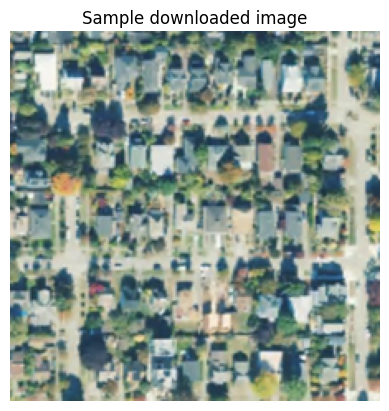

In [31]:
img_files = sorted(os.listdir(TRAIN_IMG_DIR))
img = Image.open(os.path.join(TRAIN_IMG_DIR, img_files[-1]))

plt.imshow(img)
plt.axis("off")
plt.title("Sample downloaded image")
plt.show()


(16209, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64

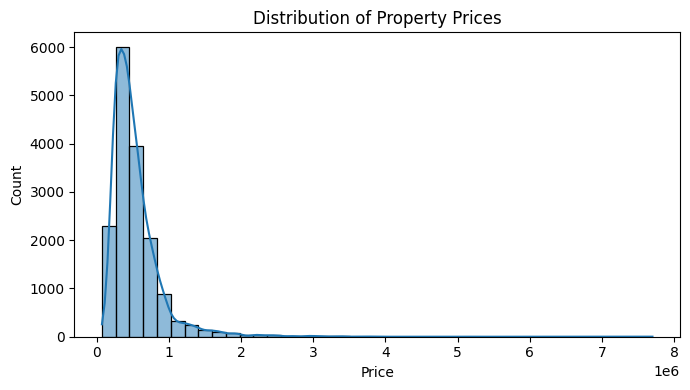

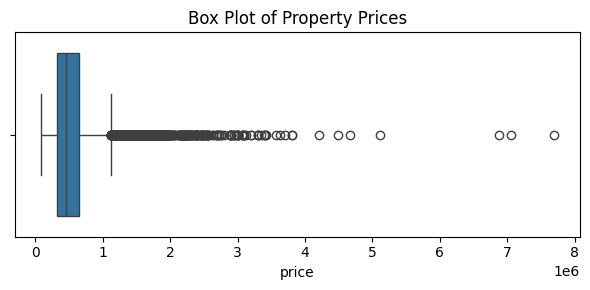

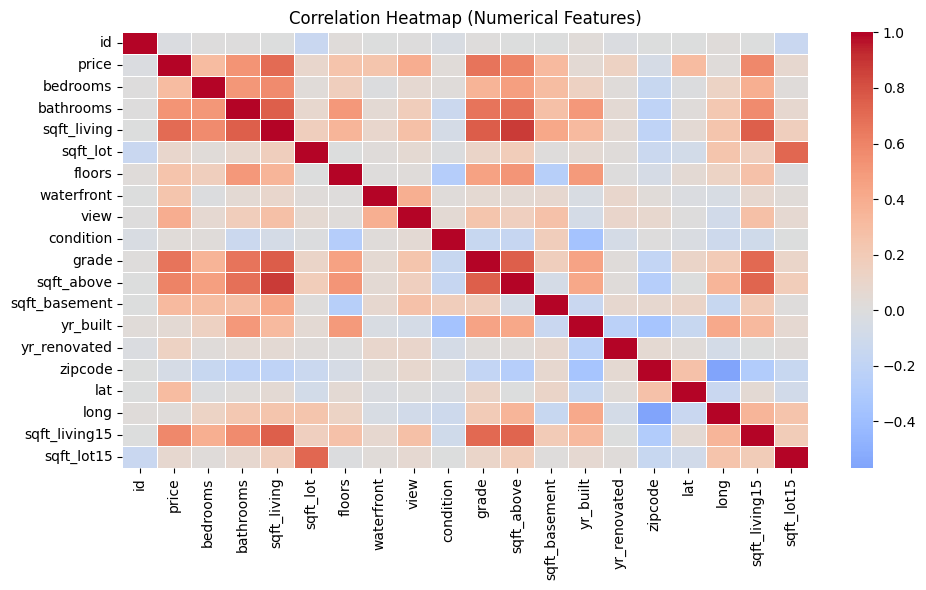

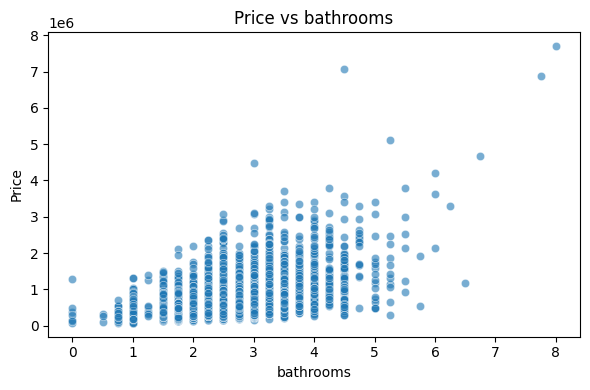

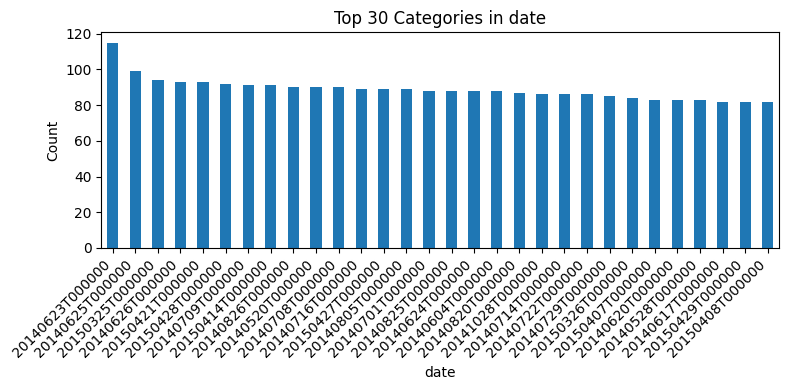

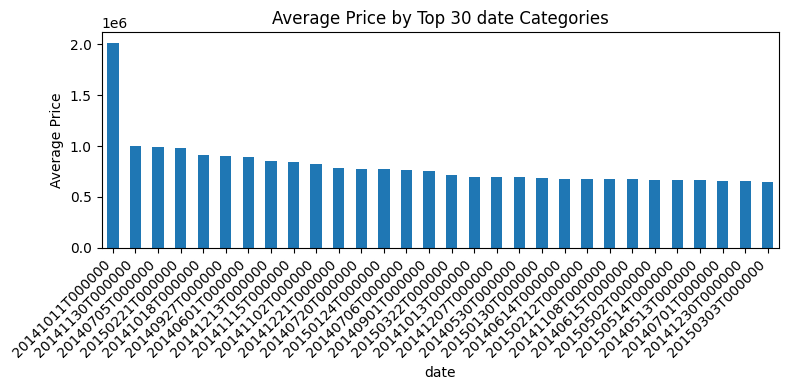

No missing values detected.


In [32]:
#  EDA

print(df.shape)
df.head() 
df.info()
df.describe()

os.makedirs("eda_figures", exist_ok=True)
plt.figure(figsize=(7, 4))
sns.histplot(df["price"], bins=40, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("eda_figures/price_distribution.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 3))
sns.boxplot(x=df["price"])
plt.title("Box Plot of Property Prices")
plt.tight_layout()
plt.savefig("eda_figures/price_boxplot.png", dpi=300)
plt.show()

num_df = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(10, 6))
sns.heatmap(
    num_df.corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.savefig("eda_figures/correlation_heatmap.png", dpi=300)
plt.show()

feature = num_df.columns.drop("price")[2]  # choose one important feature

plt.figure(figsize=(6, 4))
sns.scatterplot(x=df[feature], y=df["price"], alpha=0.6)
plt.title(f"Price vs {feature}")
plt.xlabel(feature)
plt.ylabel("Price")
plt.tight_layout()
plt.savefig(f"eda_figures/price_vs_{feature}.png", dpi=300)
plt.show()


cat_col = df.select_dtypes(include=["object", "category", "datetime"]).columns[0]
if pd.api.types.is_datetime64_any_dtype(df[cat_col]):
    df[cat_col] = df[cat_col].dt.strftime("%Y-%m-%d")

top_n = 30

counts = df[cat_col].value_counts().head(top_n)

plt.figure(figsize=(8, 4))
counts.plot(kind="bar")
plt.title(f"Top {top_n} Categories in {cat_col}")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"eda_figures/{cat_col}_top{top_n}_distribution.png", dpi=300)
plt.show()

avg_price = (
    df.groupby(cat_col)["price"]
      .mean()
      .sort_values(ascending=False)
      .head(top_n)
)

plt.figure(figsize=(8, 4))
avg_price.plot(kind="bar")
plt.title(f"Average Price by Top {top_n} {cat_col} Categories")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"eda_figures/avg_price_by_{cat_col}_top{top_n}.png", dpi=300)
plt.show()


missing = df.isna().sum()
missing = missing[missing > 0]

if len(missing) > 0:
    plt.figure(figsize=(8, 4))
    missing.plot(kind="bar")
    plt.title("Missing Values per Feature")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("eda_figures/missing_values.png", dpi=300)
    plt.show()
else:
    print("No missing values detected.")


In [33]:
# Feature extraction from images :

device = "cuda" if torch.cuda.is_available() else "cpu"

cnn = models.resnet18(weights="DEFAULT")
cnn.fc = torch.nn.Identity()

for p in cnn.parameters():
    p.requires_grad = False

cnn = cnn.to(device).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [34]:
def load_rgb_image(path):
    img = Image.open(path).convert("RGB")
    img = np.array(img).astype(np.float32) / 255.0
    return img

def extract_image_features(img_path):
    img = load_rgb_image(img_path)
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feat = cnn(img)

    return feat.cpu().numpy().squeeze()


In [35]:


# Load from cache if present
if os.path.exists(X_IMAGE_PATH) and os.path.exists(ROWS_PATH) and os.path.exists(DF_PATH):
    print("Loading cached image features...")

    X_image = np.load(X_IMAGE_PATH)
    kept_rows = np.load(ROWS_PATH)

    df = pd.read_csv(DF_PATH)

    assert len(df) == len(X_image)
    print("Cached features loaded successfully ")

# Otherwise compute and save (takes 15 minutes approx.)
else:
    print("Cache not found. Extracting image features...")

    image_features, kept_rows = [], []
    total = len(df)

    for i, (idx, row) in enumerate(df.iterrows(), start=1):
        path = os.path.join(TRAIN_IMG_DIR, f"{row['id']}.png")

        if not os.path.isfile(path):
            continue

        image_features.append(extract_image_features(path))
        kept_rows.append(idx)

        if i % 50 == 0 or i == total:
            print(f"Processed {i}/{total} rows ({100*i/total:.2f}%)")

    df = df.loc[kept_rows].reset_index(drop=True)
    X_image = np.stack(image_features)

    assert len(df) == len(X_image)
    print("Alignment check passed")

    np.save(X_IMAGE_PATH, X_image)
    np.save(ROWS_PATH, np.array(kept_rows))
    df.to_csv(DF_PATH, index=False)

    print(f"Image features cached successfully with length {len(X_image)}")


Loading cached image features...
Cached features loaded successfully 


In [36]:
#  Tabular Data preprocessing

TARGET = "price"

df = df.drop_duplicates(subset="id")
useless_cols = [
    "id",          # identifier
    TARGET,
    "date",        # temporal leakage
    "zipcode",     # high-cardinality categorical
    "yr_renovated" # sparse & noisy
]

X = df.drop(columns=useless_cols, errors="ignore")
y = df[TARGET].values

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_cols)
])


In [37]:
# Baseline model, without image feature
baseline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
])

baseline.fit(X_train, y_train)
base_pred = baseline.predict(X_test)

baseline_r2 = r2_score(y_test, base_pred)
baseline_mae = mean_absolute_error(y_test, base_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, base_pred))
print("Baseline R2:", baseline_r2)
print("Baseline RMSE:", baseline_rmse)



Baseline R2: 0.9063287377357483
Baseline RMSE: 107007.11482887481


In [38]:
# Image-only model :

X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(
    X_image, y, test_size=0.2, random_state=42
)

img_model = XGBRegressor(
    n_estimators=300, max_depth=5, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

img_model.fit(X_img_train, y_img_train)
img_pred = img_model.predict(X_img_test)

image_r2 = r2_score(y_img_test, img_pred)
image_mae = mean_absolute_error(y_img_test, img_pred)
image_rmse = np.sqrt(mean_squared_error(y_img_test, img_pred))
print("Image-only R2:", image_r2)
print("Image-only RMSE:", image_rmse)

Image-only R2: 0.3699321746826172
Image-only RMSE: 277525.63753282325


In [40]:
# Early fusion Architechture

X_tab_train = preprocessor.fit_transform(X_train)
X_tab_test = preprocessor.transform(X_test)

img_scaler = StandardScaler()
X_img_train = img_scaler.fit_transform(X_image[X_train.index])
X_img_test = img_scaler.transform(X_image[X_test.index])

X_ef_train = np.hstack([X_tab_train, X_img_train])
X_ef_test = np.hstack([X_tab_test, X_img_test])

early = XGBRegressor(
    n_estimators=800, max_depth=4, learning_rate=0.03,
    min_child_weight=10, reg_alpha=1.0, reg_lambda=2.0,
    subsample=0.8, colsample_bytree=0.6,
    random_state=42, tree_method="hist"
)

early.fit(X_ef_train, y_train)
early_pred = early.predict(X_ef_test)

early_r2 = r2_score(y_test, early_pred)
early_mae = mean_absolute_error(y_test, early_pred)
early_rmse = np.sqrt(mean_squared_error(y_test, early_pred))
print("Early Fusion R2:", early_r2)
print("Early fusion RMSE:", early_rmse)


Early Fusion R2: 0.8919748067855835
Early fusion RMSE: 114913.75548645167


In [41]:
# Late fusion Architechture with fine tuned alpha :

tabular_model_lf = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

tabular_model_lf.fit(X_tab_train, y_train)

tab_pred = tabular_model_lf.predict(X_tab_test)

image_model_lf = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

image_model_lf.fit(X_img_train, y_train)

img_pred = image_model_lf.predict(X_img_test)

alphas = np.linspace(0, 1, 21)

best_alpha = None
best_rmse = float("inf")

for alpha in alphas:
    fused_pred = alpha * tab_pred + (1 - alpha) * img_pred
    rmse = np.sqrt(mean_squared_error(y_test, fused_pred))

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = alpha

print(f"Best alpha: {best_alpha}")

late_pred = best_alpha * tab_pred + (1 - best_alpha) * img_pred

late_r2 = r2_score(y_test, late_pred)
late_mae = mean_absolute_error(y_test, late_pred)
late_rmse = np.sqrt(mean_squared_error(y_test, late_pred))

print("R2:", late_r2)
print("MAE:", late_mae)
print("RMSE:", late_rmse)



Best alpha: 0.9500000000000001
R2: 0.9075686452376373
MAE: 63937.519013326346
RMSE: 106296.53570706089


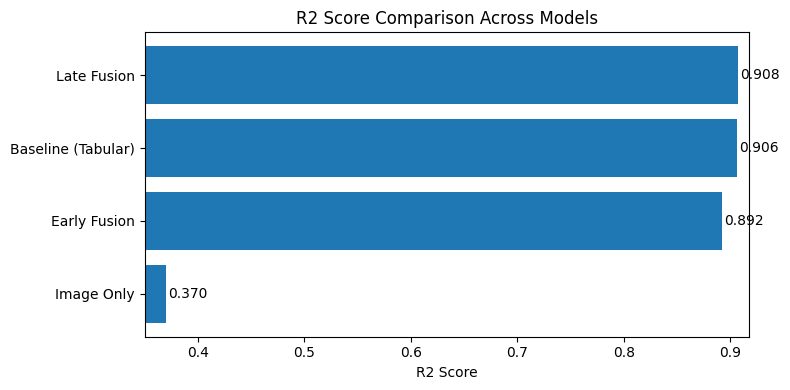

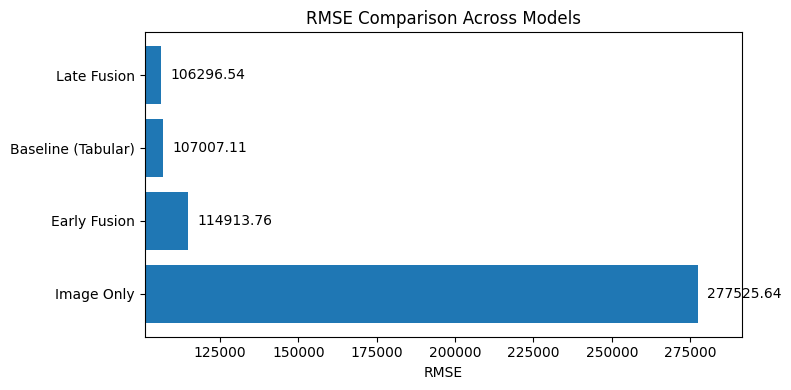

In [42]:
#  Final Comparison table

results = pd.DataFrame({
    "Model": [
        "Baseline (Tabular)",
        "Image Only",
        "Early Fusion",
        "Late Fusion"
    ],
    "R2": [
        baseline_r2,
        image_r2,
        early_r2,
        late_r2
    ],
    "MAE": [
        baseline_mae,
        image_mae,
        early_mae,
        late_mae
    ],
    "RMSE": [
        baseline_rmse,
        image_rmse,
        early_rmse,
        late_rmse
    ]
})

results_sorted = results.sort_values(by="R2", ascending=True)

os.makedirs("eval_figures", exist_ok=True)

# R2 Comparison
plt.figure(figsize=(8, 4))
plt.barh(results_sorted["Model"], results_sorted["R2"])
plt.title("R2 Score Comparison Across Models")
plt.xlabel("R2 Score")

r2_min = results_sorted["R2"].min()
r2_max = results_sorted["R2"].max()
plt.xlim(r2_min - 0.02, r2_max + 0.01)

for i, v in enumerate(results_sorted["R2"]):
    plt.text(v + 0.002, i, f"{v:.3f}", va="center")

plt.tight_layout()
plt.savefig("eval_figures/model_comparison_r2.png", dpi=300)
plt.show()


# RMSE Comparison
results_sorted_rmse = results.sort_values(by="RMSE", ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(results_sorted_rmse["Model"], results_sorted_rmse["RMSE"])
plt.title("RMSE Comparison Across Models")
plt.xlabel("RMSE")

rmse_min = results_sorted_rmse["RMSE"].min()
rmse_max = results_sorted_rmse["RMSE"].max()
plt.xlim(rmse_min - 0.05 * rmse_min, rmse_max + 0.05 * rmse_max)

for i, v in enumerate(results_sorted_rmse["RMSE"]):
    plt.text(v + 0.01 * rmse_max, i, f"{v:.2f}", va="center")

plt.tight_layout()
plt.savefig("eval_figures/model_comparison_rmse.png", dpi=300)
plt.show()


train_images\9117000170.png


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


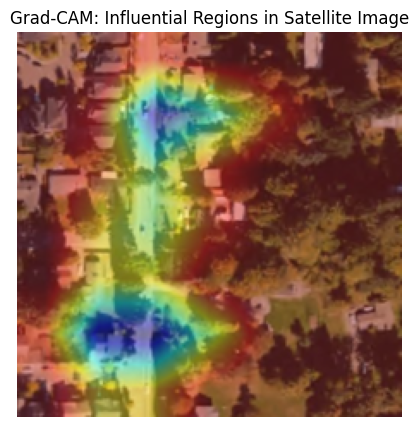

In [43]:
# Grad-CAM for Model Explainability

import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, inp, out):
        self.activations = out

    def _save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output.backward(torch.ones_like(output))

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.detach().cpu().numpy()[0]


sample_id = df.iloc[0]["id"]
img_path = os.path.join(TRAIN_IMG_DIR, f"{sample_id}.png")
print(img_path)
img = Image.open(img_path).convert("RGB")
img_np = np.array(img)

img_np = np.array(img)          # convert PIL → ndarray
input_tensor = transform(img_np).unsqueeze(0).to(device)

input_tensor.requires_grad = True

target_layer = cnn.layer4[-1].conv2

gradcam = GradCAM(cnn, target_layer)
cam = gradcam.generate(input_tensor)

cam = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

overlay = 0.4 * heatmap / 255 + 0.6 * img_np / 255

plt.figure(figsize=(5, 5))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM: Influential Regions in Satellite Image")
plt.savefig("eval_figures/gradcam_example.png", dpi=300, bbox_inches="tight")
plt.show()


In [44]:
# Finalized model : *****Late fusion*****
# I have trained the final model on the entire test dataset

print(f"Training final late-fusion models with alpha = {best_alpha}")

X_tab_full = preprocessor.fit_transform(X)

final_tabular_model = XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

final_tabular_model.fit(X_tab_full, y)

img_scaler = StandardScaler()
X_img_full = img_scaler.fit_transform(X_image)

final_image_model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)

final_image_model.fit(X_img_full, y)

print(" Final tabular + image models trained on full dataset")


Training final late-fusion models with alpha = 0.9500000000000001
 Final tabular + image models trained on full dataset


In [45]:
# Prediction on test2.xlsx

test_df = pd.read_excel("test2.xlsx")
test_df = test_df.drop_duplicates(subset="id")

# Downloading the test data's satellite images (if not done before)
print("Downloading satellite images for test2.xlsx...")
if (os.path.exists(X_IMAGE_TEST2_PATH) and os.path.exists(VALID_ROWS_TEST2_PATH) and os.path.exists(FILTERED_TEST2_DF_PATH)):
    print("Test image features already present in artifact folder. No need to download test images again..")

else:
    download_images(
        df=test_df,
        img_dir=TEST_IMG_DIR,
        max_images=None
    )
    print("Download Completed !!")



# LOAD FROM CACHE IF AVAILABLE 
if (
    os.path.exists(X_IMAGE_TEST2_PATH)
    and os.path.exists(VALID_ROWS_TEST2_PATH)
    and os.path.exists(FILTERED_TEST2_DF_PATH)
):
    print("Loading cached image features for test2.xlsx...")

    X_image_test2 = np.load(X_IMAGE_TEST2_PATH)
    valid_rows_test2 = np.load(VALID_ROWS_TEST2_PATH)
    test_df = pd.read_csv(FILTERED_TEST2_DF_PATH)

    assert len(test_df) == len(X_image_test2)
    print("Cached test2 image features loaded successfully")

# OTHERWISE EXTRACT AND SAVE
else:
    print("Extracting CNN image features for test2.xlsx...")

    image_features_test2 = []
    valid_rows_test2 = []

    count = 1
    total = len(test_df)

    for idx, row in test_df.iterrows():
        img_path = os.path.join(TEST_IMG_DIR, f"{row['id']}.png")

        if count % 10 == 0 or count == total:
            print(f"Processed {count}/{total} rows ({100*count/total:.2f}%)")
        count += 1

        if not os.path.isfile(img_path):
            print(f" Missing image for id {row['id']} — skipping")
            continue

        feat = extract_image_features(img_path)
        image_features_test2.append(feat)
        valid_rows_test2.append(idx)

    test_df = test_df.loc[valid_rows_test2].reset_index(drop=True)
    X_image_test2 = np.stack(image_features_test2)

    assert len(test_df) == len(X_image_test2)

    # ---------- SAVE CACHE ----------
    np.save(X_IMAGE_TEST2_PATH, X_image_test2)
    np.save(VALID_ROWS_TEST2_PATH, np.array(valid_rows_test2))
    test_df.to_csv(FILTERED_TEST2_DF_PATH, index=False)

    print("Test2 image features cached successfully")

# PREPROCESSING... same as before
X_test2 = test_df.copy()
useless_cols = [
    "id",          # identifier
    "date",        # temporal leakage
    "zipcode",     # high-cardinality categorical
    "yr_renovated" # sparse & noisy
]

X_test2 = X_test2.drop(columns=useless_cols, errors="ignore")

X_tab_test2 = preprocessor.transform(X_test2)

X_image_test2 = img_scaler.transform(X_image_test2)


# LATE FUSION PREDICTION
tab_pred_test2 = final_tabular_model.predict(X_tab_test2)
img_pred_test2 = final_image_model.predict(X_image_test2)

final_price_pred = best_alpha * tab_pred_test2 + (1 - best_alpha) * img_pred_test2


# SAVE OUTPUT CSV 
output_df = test_df.copy()
output_df["predicted_price"] = final_price_pred

output_path = "24117013.csv"
output_df[["id", "predicted_price"]].to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")


Test image features already present in artifact folder. No need to download test images again..
Loading cached image features for test2.xlsx...
Cached test2 image features loaded successfully
Predictions saved to 24117013.csv
